# Simple Loop (简单回路)

- 用一条连续线路串联起每个白色格子。必须形成一个环路。
- 线只能从上下左右格子走，不能对角线走；

-------

- Draw a single loop through all unshaded cells, avoiding all shaded cells.
- Can't move diagonally. Only horizontally or vertically.

> 💡 Hamiltonian cycle



In [7]:
import random
import networkx as nx
import numpy as np
import math
import gurobipy as grb
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Rectangle

In [ ]:
def readInstance(path):

    file_name = f"../assets/data/Simpleloop/{path}.txt"

    m = 0
    n = 0
    grids = None
    print( f"READING FILE {file_name}" )
    if not os.path.isfile(file_name):
        print('File does not exist')
    else:
        
        with open(file_name) as file:
            firstline = file.readline().strip().split(" ")
            m = int(firstline[0])
            n = int(firstline[1])
            grids = [[-1 for _ in range(n)] for _ in range(m)]

            for idx in range(m):
                line = file.readline().strip().split(" ")
                assert len(line) == n
                
                for j in range(n):
                    if line[j] != '.':
                        grids[idx][j] = int(line[j])
    return m, n, grids

if __name__ == "__main__":
    m, n, grids = readInstance("20x20easy1")
    # print(grids)
    for line in grids:
        print(line)

READING FILE ../assets/data/Simpleloop/20x20easy1.txt
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

READING FILE ../assets/data/Simpleloop/20x20easy1.txt
Model Status: optimal
Total arcs: 254.0
Running time: 0.138 seconds


/var/folders/wp/zfkgqzvj2lq6fk2gy0rbmq6m0000gn/T/ipykernel_68914/4050741418.py:30: UserWarning: linked SCIP 9.02 is not recommended for this version of PySCIPOpt - use version 9.2.1
  model = Model("SimpleLoop")


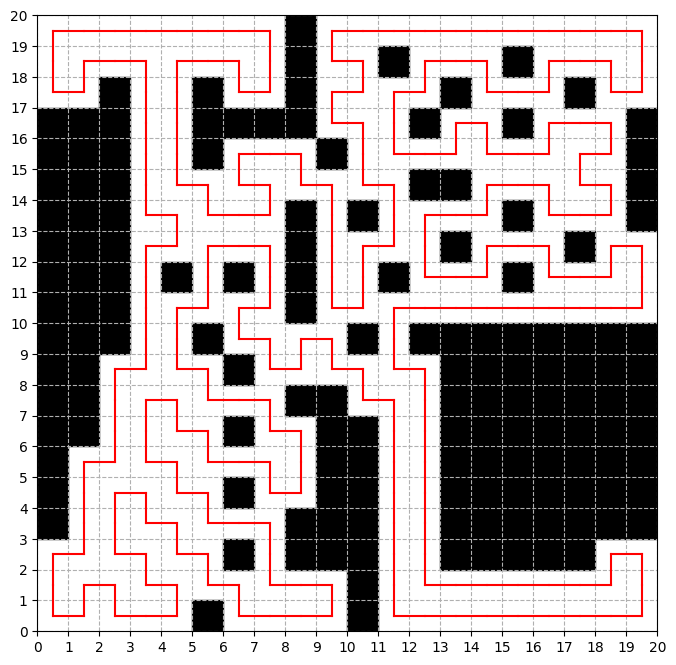

In [ ]:
from pyscipopt import Model, quicksum
import time
import networkx

def cell2Arcs(m, n, i, j):
    arcs = []
    if i != m - 1:
        arcs.append((i * n + j, (i + 1) * n + j))
    if j != n - 1:
        arcs.append((i * n + j, i * n + j + 1))
    return arcs

def cell2Arcs2(m, n, i, j):
    arcs = []
    if i != 0:
        arcs.append(((i - 1) * n + j ,i * n + j))
    if i != m - 1:
        arcs.append((i * n + j, (i + 1) * n + j))
    if j != 0:
        arcs.append((i * n + j - 1, i * n + j))
    if j != n - 1:
        arcs.append((i * n + j, i * n + j + 1))
    return arcs

def SimpleLoopSolverWithSCIP(m, n, grids):
    
    starttime = time.time()
    model = Model("SimpleLoop")
    x = dict()
    
    all_arcs = []
    for i in range(m):
        for j in range(n):
            cur_arc = cell2Arcs(m, n, i, j)
            for (a, b) in cur_arc:
                x[a, b] = model.addVar(
                    vtype = "B", 
                    name = f"x[{a},{b}]"
                )
                all_arcs.append((a, b))
                
    for i in range(m):
        for j in range(n):
            if grids[i][j] == 1:
                cur_arc = cell2Arcs2(m, n, i, j)
                model.addCons(quicksum(x[a, b] for (a, b) in cur_arc) == 0, name = f"0_cell_{i}_{j}")
            elif grids[i][j] == 0:
                cur_arc = cell2Arcs2(m, n, i, j)
                model.addCons(quicksum(x[a, b] for (a, b) in cur_arc) == 2, name = f"1_cell_{i}_{j}")
            
    model.setObjective(quicksum(x[a, b] for (a, b) in all_arcs), 'minimize')
    model.hideOutput()
    def addCut(edges):
        G = networkx.Graph()
        G.add_edges_from(edges)
        components = list( list(c) for c in networkx.connected_components(G))
        # print(f"Totally: {len(components)} subtours!")
        if len(components) == 1:
            return False
        else:
            for component in components:
                prev = -1
                curr = component[0]
                cntt = len(component)
                nodeSet = set(component)
                temp = list()
                while cntt > 0:
                    for direct in [- n , n , -1, 1]:
                        target = direct + curr 
                        curredge = (curr, target) if curr < target else (target, curr)
                        if target in nodeSet and target != prev and curredge in edges:
                            temp.append(curredge)
                            prev = curr 
                            curr = target 
                            break 
                    cntt -= 1
                model.freeTransform()
                model.addCons(quicksum(x[a, b] for (a, b) in temp) <= len(temp) - 1)
            return True
    
    arcs = []
    while True:
        model.optimize()
        edges = []
        for (a, b) in x.keys():
            if model.getVal( x[a, b]) > 1e-1:
                edges.append((a, b))
        if not addCut(edges):
            print(f"Model Status: {model.getStatus()}")
            print(f"Total arcs: {model.getObjVal()}")
            sol = model.getBestSol()
            for (a, b) in all_arcs:
                if sol[x[a, b]] > 1e-1:
                    arcs.append([a, b])
            break
    endtime = time.time()
    print(f"Running time: {(round(endtime - starttime, 3)) } seconds")
    return arcs

    
if __name__ == "__main__":
    m, n, grids = readInstance("20x20easy1")
    result = SimpleLoopSolverWithSCIP(m, n, grids)


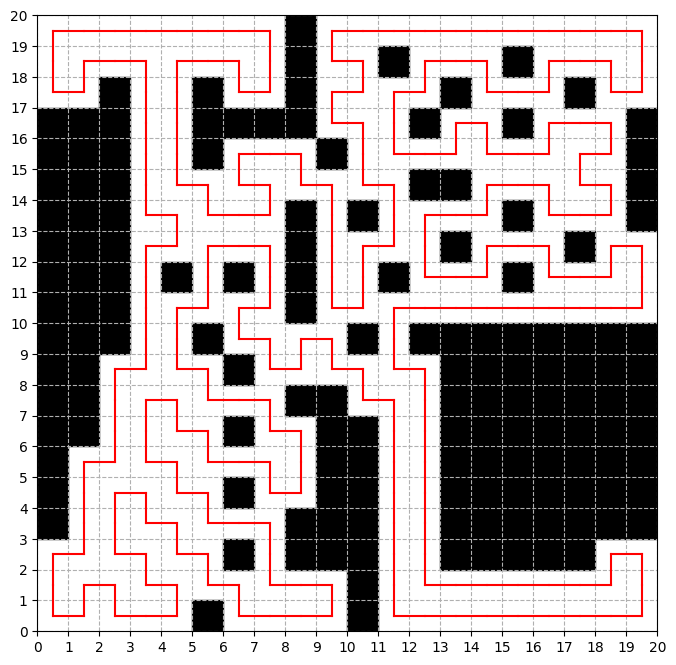

In [12]:
def coordinatesParser(m, n, idx):
    """_summary_
        进行坐标转换 
    Args:
        m (_type_): _description_
        n (_type_): _description_
        idx (_type_): _description_

    Returns:
        _type_: _description_
    """
    ori_x , ori_y = idx // n, idx % n 
    return (0.5 + ori_y, 0.5 + ( m - ori_x - 1) )

def Vis(m, n, grid, result):
    plt.figure(figsize=(8,8))

    ax = plt.gca()
    x_major_locator = MultipleLocator(1)
    y_major_locator = MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    # 把x/y轴的主刻度设置为1的倍数
    ax.yaxis.set_major_locator(y_major_locator)

    plt.xlim(0,n)
    plt.ylim(0,m)

    plt.grid(linestyle = "--")

    # 绘制无法被访问的方块
    for i in range(m):
        for j in range(n):
            if grids[i][j] == 1:    
                new_coor = coordinatesParser(m, n, i * n + j)
                ax.add_patch(Rectangle((new_coor[0] - 0.5, new_coor[1] - 0.5), 1, 1, color = "black"))

    # 绘制结果连线

    for line in result["arcs"]:
        dot1 = coordinatesParser(m, n, line[0])
        dot2 = coordinatesParser(m, n, line[1])
        plt.plot([dot1[0], dot2[0]], [dot1[1], dot2[1]], linestyle="-", color = "red") 

    plt.show()

if __name__ == "__main__":
    Vis(m, n, grids, {"arcs": result})

## Gurobi Solver (Verified!)

In [ ]:
def SimpleLoopwithLazyCuts(m, n, grids):
    """_summary_

    Args:
        m (_type_): _description_
        n (_type_): _description_
        grids (_type_): _description_
    """
    SimpleLoop = grb.Model("SimpleLoop")
    x = {}
    to_dict = {}
    for i in range(m):
        for j in range(n):
            if grids[i][j] == 1:
                continue
            cur_idx = i * n + j
            to_dict[cur_idx] = []
            directions = [
                (0, -1),
                (0, 1),
                (1, 0),
                (-1, 0)
            ]
            for (xx, yy) in directions:
                newX = i + xx
                newY = j + yy
                if newX < 0 or newX >= m or newY < 0 or newY >= n or grids[newX][newY] == 1:
                    continue
                tar_idx = newX * m + newY
                x[cur_idx, tar_idx] = SimpleLoop.addVar(
                    vtype = grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{cur_idx},{tar_idx}]"
                )
                to_dict[cur_idx].append(tar_idx)

    print(f"All Nodes need to be filled is {len(to_dict.keys())}")
    SimpleLoop.modelSense = grb.GRB.MINIMIZE
    SimpleLoop.Params.lazyConstraints = 1
    SimpleLoop.update()
    
    for i in to_dict.keys():
        SimpleLoop.addConstr(grb.quicksum(x[i, j] for j in to_dict[i]) == 1, name = f"Out_Balance_Node_{i}")
        SimpleLoop.addConstr(grb.quicksum(x[j, i] for j in to_dict[i]) == 1, name = f"In_Balance_Node_{i}")
    
    def subtourelim(model, where):
        if (where == grb.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            # 从新的 MIP 解决方案中检索值。
            G = nx.Graph()
            nodes_appear = []
            for (i, j) in x.keys():
                if (x_sol[i, j] > 0.9):
                    if i not in nodes_appear:
                        nodes_appear.append(i)
                    if j not in nodes_appear:
                        nodes_appear.append(j)
                    G.add_edge(i, j, weight = 1)
            components = [list(c) for c in nx.connected_components(G)]
            print("The length is " + str(len(components)))
            for component in components:
                if (len(component) < len(nodes_appear)):
                    # print("Add Cut!")
                    model.cbLazy(grb.quicksum(x[i,j] for i in component for j in component if j in to_dict[i]) <= len(component) - 1)
    SimpleLoop._x = x
    SimpleLoop.optimize(subtourelim)
    SimpleLoop.optimize()
    # SimpleLoop.write("SimpleLoop.lp")

    ofv = None
    seq = []
    arcs = []
    solType = None
    gap = None
    lb = None
    ub = None
    runtime = None
    if (SimpleLoop.status == grb.GRB.status.OPTIMAL):
        solType = 'IP_Optimal'
        ofv = SimpleLoop.getObjective().getValue()
        print(ofv)
        for i, j in x:
            if (x[i, j].x > 0.5):
                arcs.append([i, j])
        # assert len(arcs) == len(nodes_pos) - 1
        # currentNode = nodeIDs[0]
        # seq.append(currentNode)
        # while (len(arcs) > 0):
        #     for i in range(len(arcs)):
        #         if (arcs[i][0] == currentNode):
        #             currentNode = arcs[i][1]
        #             seq.append(currentNode)
        #             arcs.pop(i)
        #             break
        gap = 0
        lb = ofv
        ub = ofv
        runtime = SimpleLoop.Runtime
    elif (SimpleLoop.status == grb.GRB.status.TIME_LIMIT):
        solType = 'IP_TimeLimit'
        ofv = None
        seq = []
        gap = SimpleLoop.MIPGap
        lb = SimpleLoop.ObjBoundC
        ub = SimpleLoop.ObjVal
        runtime = SimpleLoop.Runtime

    return {
        "TotalCost": ofv,
        "runtime": runtime,
        "arcs": arcs
    }
result = SimpleLoopwithLazyCuts(m, n, grids)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
All Nodes need to be filled is 254
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 508 rows, 766 columns and 1532 nonzeros
Model fingerprint: 0x10fee560
Variable types: 0 continuous, 766 integer (766 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 226 rows and 228 columns
Presolve time: 0.01s
Presolved: 282 rows, 538 columns, 1030 nonzeros
Variable types: 0 continuous, 538 integer (538 binary)
The length is 78

Root relaxation: objective 2.540000e+02, 339 iterations, 0.00 seconds (0.00 work units)
The length is 64

    Nodes    |    Current Node    |     Objective Bounds      |     Wor